In [1]:
import numpy as np
import sys
import time
import os
import h5py
import os.path as op
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import array
from multiprocessing import Pool
import nyroglancer
from edgelist_methods import *
from par_funcs *
%matplotlib inline
sys.path.append('..')
path_to_folder = '/Users/chandansingh/drive/janelia/conv_net_scripts/'
path_to_data = path_to_folder + 'data/'


# -------------------------------- parameters ---------------------------------------
gt_seg = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_seg_thick.h5'
gt_aff = '/groups/turaga/home/turagas/data/FlyEM/fibsem_medulla_7col/tstvol-520-1-h5/groundtruth_aff.h5'
# pred_file = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/sample_A_x1_y1_z1_xy1.h5'
# pred_file_2 = '/groups/turaga/home/turagas/research/caffe_v2/processed/bock2/120000/cutout_3k.h5'
pred_file = '/groups/turaga/home/turagas/turagalab/FROM_TIER2/singhc/train/output_200000/tstvol-1_2.h5'

out_folder = '/nobackup/turaga/singhc/par_zwshed_3/'
outname = out_folder+'out.h5'
threshes = [2000]
cmap = matplotlib.colors.ListedColormap(np.vstack(((0, 0, 0), np.random.rand(255, 3))))
NUM_WORKERS = 16
MAX_LEN = 200

# Divide Volumes, set up args

In [2]:
from par_funcs import partition_subvols
args,starts,ends,dims,num_vols = partition_subvols(pred_file,out_folder,max_len=MAX_LEN)

dims [432 432 432]
num_vols [3 3 3]
deltas [144 144 144]


# Call Watershed

In [3]:
from par_funcs import zwshed_h5_par
p = Pool(NUM_WORKERS)
p.map(zwshed_h5_par, args)

finished /nobackup/turaga/singhc/par_zwshed_3/0_285_285_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_285_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_285_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_141_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_141_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_0_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_0_285_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_285_141_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_285_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/141_141_0_vol0/ watershed
finished /nobackup/turaga/singhc/par_zwshed_3/0_141_141_vol0/ watershed
finish

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

# Stitch

i,x,y,z 0 0 0 0
i,x,y,z 1 0 0 1
	filter merges...
	merging numbers, 183 keys ... 


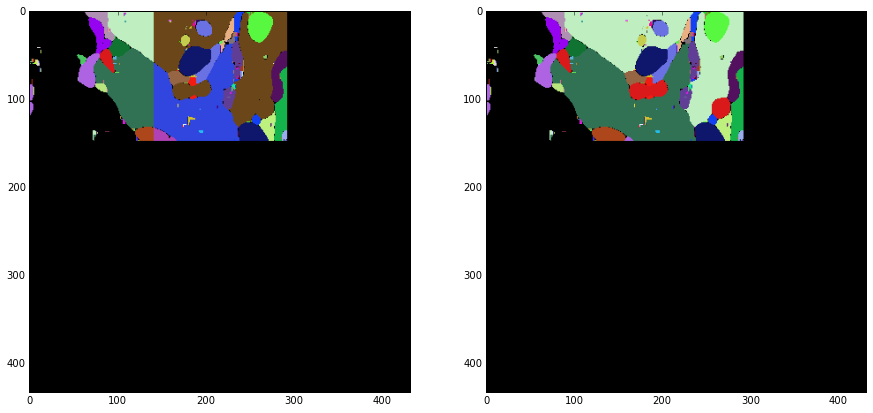

/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:95: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/groups/turaga/home/singhc/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:96: DeprecationWarning: assignment will raise an error in the future, most likely because your index result shape does not match the value array shape. You can use `arr.flat[index] = values` to keep the old behaviour.


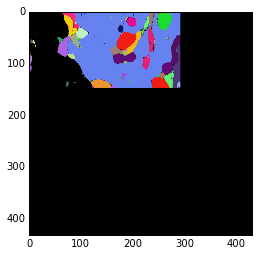

In [7]:
if op.isfile(outname):
    os.remove(outname)
f = h5py.File(outname, 'a')
dset_seg = f.create_dataset('seg', dims, dtype='uint64', chunks=True)
inc,re,merges,rgs=0,{},{},{}
X,Y,Z = (1,1,2)
# calc merges, set dset_seg, rg with incrementing
for x in range(X): #num_vols[0]):
    for y in range(Y): #num_vols[1]):        
        for z in range(Z): #num_vols[2]): 
            i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
            arg,s,e = args[i],starts[i],ends[i]
            basic_file = h5py.File(arg[-1]+'basic.h5','r')
            seg,rg = np.array(basic_file['seg']),np.array(basic_file['rg'])
            seg[seg!=0]+=inc
            rg[:,:2] += inc
            rgs[i] = rg
            inc = np.max(seg)
            print "i,x,y,z",i,x,y,z
            if not z==0: 
                re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]:e[1],s[2]+3],edge_maxes=seg[:,:,3], re=re, merges=merges)
            if not y==0:
                re,merges = calc_merges(edge_mins=dset_seg[s[0]:e[0],s[1]+3,s[2]:e[2]],edge_maxes=seg[:,3,:],re=re,merges=merges)
            if not x==0:
                re,merges = calc_merges(edge_mins=dset_seg[s[0]+3,s[1]:e[1],s[2]:e[2]],edge_maxes=seg[3,:,:],re=re, merges=merges)
            dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]] = seg[:,:,:]

merges_filtered = filter_merges(merges)            
rgs = merge(merges_filtered,rgs,(X,Y,Z),(args,starts,ends),f,max_val=inc,p=True)
renum,seg_sizes,rgs = renum_all(f['seg'],rgs,(X,Y,Z),(args,starts,ends),f,p=True)


# save
dset_seg_sizes = f.create_dataset('seg_sizes', data=np.array(seg_sizes))
for key in rgs:
    rg_dset = f.create_dataset('rg_'+str(key),data=np.array(rgs[key]))
dset_starts = f.create_dataset('starts',data=np.array(starts))
dset_ends = f.create_dataset('ends',data=np.array(ends))                               
f.close()

In [8]:
# stitch methods
def calc_merges(edge_mins,edge_maxes, re, merges={}):
    edge_mins = edge_mins.ravel()
    edge_maxes = edge_maxes.ravel()
    for j in range(len(edge_mins)):
        edge_min = edge_mins[j]
        edge_max = edge_maxes[j]
        if not edge_min==0 and not edge_max==0:
            if not edge_max==edge_min:
                if edge_max in re: # already in map
                    old_min = re[edge_max]
                    merge_max = max(old_min,edge_min)
                    merge_min = min(old_min,edge_min)
                    if not merge_max==merge_min:
                        re[merge_max] = merge_min
                        add_or_inc(merge_max,merge_min,merges)
            re[edge_max] = edge_min
            add_or_inc(edge_max,edge_min,merges)
    return re, merges  

def filter_merges(merges):
    COUNT_THRESH = 0
    print "\tfilter merges..."
    # only keep strongest edges
    renums = {}
    count_maxes = {}
    for pair in merges:
        count = merges[pair]
        e1,e2 = pair
        if e1 in count_maxes:
            if count > count_maxes[e1]:
                renums[e1] = e2
                count_maxes[e1] = count
        else:
            renums[e1] = e2
            count_maxes[e1] = count
    
    # compress merges
    sum_counts = 0
    for key in merges:
        sum_counts += merges[key]
    renums_filtered = {}
    print "\tmerging numbers,",len(renums.keys()),"keys ... "            
    for key in renums:
        val = renums[key]
        if merges[(key,val)] > COUNT_THRESH:
            while val in renums:
                val = renums[val]
            renums_filtered[key] = val
    return renums_filtered

def merge(merges_filtered,rgs,(X,Y,Z),(args,starts,ends),f,max_val=1e5,p=False):     
    # merge segs
#     print "\tbefore nsegs=",len(np.unique(dset_seg)),"num0=",np.sum(dset_seg==0)
    if p:
        fig = plt.figure(figsize=(15, 7))
        plt.subplot(1,2,1)
        plt.imshow(dset_seg[0, :, :], cmap=cmap)
        
    mp = np.arange(0,max_val+1,dtype='uint64')
    mp[merges_filtered.keys()] = merges_filtered.values()
    for x in range(X): #num_vols[0]):
        for y in range(Y): #num_vols[1]):        
            for z in range(Z): #num_vols[2]): 
                i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
                arg,s,e = args[i],starts[i],ends[i]
                seg = np.array(dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]])
                f['seg'][s[0]:e[0],s[1]:e[1],s[2]:e[2]] = mp[seg]
    if p:
        plt.subplot(1,2,2)
        plt.imshow(f['seg'][0, :, :], cmap=cmap)
    plt.show()
    
    # merge rgs
    for key in rgs:
        rg = rgs[key]
        rg_to_renum = rg[:,:2].astype('int')
        rg[:,:2] = mp[rg_to_renum]
        keeps = rg[:,0]!=rg[:,1]
        rg_filtered = rg[keeps,:]
        rgs[key] = rg_filtered
    
                
    return rgs

def renum_all(seg,rgs,(X,Y,Z),(args,starts,ends),f,p=False): # there must be at least one background pixel   
    segId,seg_sizes = np.unique(seg,return_counts=True) # this might have to be done in parts
    renum = np.zeros(segId.max()+1,dtype=np.uint64)
    renum[segId] = np.arange(0,len(segId)+1) 

    for x in range(X): #num_vols[0]):
        for y in range(Y): #num_vols[1]):        
            for z in range(Z): #num_vols[2]): 
                i = x*num_vols[1]*num_vols[2]+y*num_vols[2]+z
                arg,s,e = args[i],starts[i],ends[i]
                seg = np.array(dset_seg[s[0]:e[0],s[1]:e[1],s[2]:e[2]])
                f['seg'][s[0]:e[0],s[1]:e[1],s[2]:e[2]] = renum[seg]
    if p:
        plt.imshow(dset_seg[0, :, :], cmap=cmap)
    plt.show()
    
    # renumber rgs
    for key in rgs:
        rg = rgs[key]
        rg_to_renum = rg[:,:2].astype('int64')
#         rg[:,:2] = renum[rg_to_renum]
        rgs[key] = rg

    return renum, seg_sizes, rgs

# Agglomeration

In [ ]:
def merge_by_thresh(seg,seg_sizes,rg,thresh):
    re = {}
    seg_max = np.max(seg)
    print "calculating renums..."
    for i in range(rg.shape[0]):
        n1,n2,w = rg[i,:]
        size = w*w*thresh
        if seg_sizes[n1] < size or seg_sizes[n2] < size:
            re[n2]=n1
            seg_sizes[n1]+=seg_sizes[n2]
            seg_sizes[n2]+=seg_sizes[n1]
    re_filtered = {}
    print "filtering renums..."
    for key in re:
        val = re[key]
        while val in re:
            val = re[val]
        if key < seg_max and val < seg_max:
            re_filtered[key] = val
    print "renumbering..."
    mp = np.arange(0,seg_max+1,dtype='uint64')
    mp[re_filtered.keys()] = re_filtered.values()
    seg = mp[seg]
    return seg

num,thresh = 0,2000
f = h5py.File(outname, 'a')
s,e = f['starts'][num],f['ends'][num]
seg = f['seg'][s[0]:e[0],s[1]:e[1],s[2]:e[2]]
seg_sizes = np.array(f['seg_sizes'])
rg = np.array(f['rg_'+str(num)])
f.close()

seg_merged = merge_by_thresh(seg,seg_sizes,rg,thresh)
plt.subplot(1,2,1)
plt.imshow(seg[0,:,:], cmap=cmap)
plt.subplot(1,2,2)
plt.imshow(seg_merged[0,:,:], cmap=cmap)

# Visualize

In [ ]:
v = nyroglancer.Viewer()
v.set_hostname("localhost:8888")
v.put(gt_seg, resolution=[1,1,1], vtype="segmentation", name="raw")
v.show()